## Create a context

In [1]:
# Initialize the spark environment (takes ~ 1min)
import pyspark
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

In [2]:
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

## Preparation of data (get it into parquet)

In [4]:
from pyspark.ml.classification import LogisticRegression

In [8]:
# Load thrust data
dataPath = "thrust.csv"
df = sqlc.read.format("csv")\
  .option("header","true")\
  .option("inferSchema", "true")\
  .load(dataPath)

In [10]:
parquetPath = '/home/ec2-user/SageMaker/vs3br/parquet'
df.write.parquet(parquetPath)

Getting data back from parquet:

In [11]:
df = sqlc.read.parquet(parquetPath)

## MLlib based analysis

In [12]:
# Data pre-processing before building a model
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

assembler = VectorAssembler(inputCols=['x1','x2','x3','x4','x5','x6'], outputCol="features")
stages = [assembler]

In [13]:
transf_df = assembler.transform(df)
transf_df = transf_df.select(['features', 'y'])
transf_df.show(3)

+--------------------+----+
|            features|   y|
+--------------------+----+
|[2140.0,20640.0,3...|4540|
|[2016.0,20280.0,3...|4315|
|[1905.0,19860.0,2...|4095|
+--------------------+----+
only showing top 3 rows



In [14]:
# train test split- 70, 30%
splits = transf_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [15]:
# Linear regression
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='y', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.6828351176052072,0.10465509119780525,0.14343074004908632,6.05025824610963,0.35049506905260824,-13.54821002587615]
Intercept: -3932.2601615745707
RMSE: 24.518578
r2: 0.996931


## Visualization of results

In [16]:
#Prediction
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","y","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="y",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|   y|            features|
+------------------+----+--------------------+
|3042.8185131472856|3074|[1388.0,17870.0,2...|
|  3073.43536754068|3080|[1407.0,17910.0,2...|
| 3112.434251240362|3125|[1440.0,18030.0,2...|
|3364.3837534357235|3368|[1487.0,18012.0,2...|
| 3324.557782722569|3210|[1489.0,18700.0,2...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.995671


In [34]:
y = lr_predictions.select('y').toPandas()
preds = lr_predictions.select('prediction').toPandas()

In [38]:
residuals = preds['prediction'] - y['y']

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

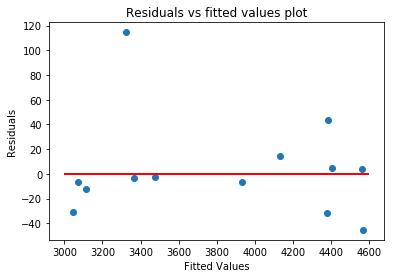

In [48]:
fig = plt.figure()
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs fitted values plot')
plt.scatter(preds['prediction'], residuals)
plt.hlines(y=0, xmin=3000, xmax=4600, linewidth=2, color='r')

The plot is almost horizontal indicating a linear model is justified. But this can be much improved using moder data points